# Global bike ownership trends

Data source: Oke, O., Khalla, B., Love, D. C., Siddiqui, S. (2015), Tracking global bicycle ownership patterns, Journal of Transport & Health, 2(4), 490-501 ([paper](https://www.sciencedirect.com/science/article/abs/pii/S2214140515006787), [supplementary material](https://www.ce.jhu.edu/sauleh/publications/2015OkeBhallaLoveSiddiquiSupplement.pdf))

In [65]:
import os
import configparser

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from pypalettes import load_cmap
from pypalettes import get_hex
from matplotlib.lines import Line2D

from matplotlib import font_manager

In [145]:
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\PublicSans-Bold.ttf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\PublicSans-Thin.ttf')

In [3]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

## Load data

In [23]:
# Load bike ownership data
df = pd.read_csv("2015OkeBhallaLoveSiddiqui_data.csv")
df["ISO"] = df["ISO"].str.replace("ROM", "ROU")
df.head()

,Year,ISO,PBO,Households,Group
0,1989.0,AUS,47.00,"7,760,322",2.0
1,1989.0,BEL,54.79,"3,608,178",2.0
2,1989.0,CAN,60.72,"8,281,530",2.0
3,1989.0,CHE,62.48,"2,543,540",2.0
4,1989.0,DEU,72.27,"26,977,920",1.0


In [180]:
# load countries shapefile
file = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(file, file)))

#rename incorrect ISO code for South Sudan
countries.loc[countries["ADMIN"]=="South Sudan", "ADM0_A3"] = "SSD"

print(len(countries))
countries.head(2)

258


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,GEOU_DIF,GEOUNIT,GU_A3,SU_DIF,SUBUNIT,SU_A3,BRK_DIFF,NAME,NAME_LONG,BRK_A3,BRK_NAME,BRK_GROUP,ABBREV,POSTAL,FORMAL_EN,FORMAL_FR,NAME_CIAWF,NOTE_ADM0,NOTE_BRK,NAME_SORT,NAME_ALT,MAPCOLOR7,MAPCOLOR8,MAPCOLOR9,MAPCOLOR13,POP_EST,POP_RANK,POP_YEAR,GDP_MD,...,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT,FCLASS_ISO,TLC_DIFF,FCLASS_TLC,FCLASS_US,FCLASS_FR,FCLASS_RU,FCLASS_ES,FCLASS_CN,FCLASS_TW,FCLASS_IN,FCLASS_NP,FCLASS_PK,FCLASS_DE,FCLASS_GB,FCLASS_BR,FCLASS_IL,FCLASS_PS,FCLASS_SA,FCLASS_EG,FCLASS_MA,FCLASS_PT,FCLASS_AR,FCLASS_JP,FCLASS_KO,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,IDN,0,Indonesia,IDN,0,Indonesia,IDN,0,Indonesia,Indonesia,IDN,Indonesia,None,Indo.,INDO,Republic of Indonesia,None,Indonesia,None,None,Indonesia,None,6,6,6,11,270625568.0,17,2019,1119190,...,Індонезія,انڈونیشیا,Indonesia,印度尼西亚,印度尼西亞,Admin-0 country,None,Admin-0 country,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,MYS,0,Malaysia,MYS,0,Malaysia,MYS,0,Malaysia,Malaysia,MYS,Malaysia,None,Malay.,MY,Malaysia,None,Malaysia,None,None,Malaysia,None,2,4,3,6,31949777.0,15,2019,364681,...,Малайзія,ملائیشیا,Malaysia,马来西亚,馬來西亞,Admin-0 country,None,Admin-0 country,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."


In [48]:
# merge data
_countries = countries.copy()
gdf = pd.merge(_countries[['featurecla','SOVEREIGNT','SOV_A3','ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
                           'ADM0_A3', "geometry"]],
               df.drop_duplicates(subset=["ISO", "Group"]).dropna(),
               left_on="ADM0_A3", right_on="ISO", how="left")
gdf = gdf.to_crs(4087)
gdf["area_size"] = gdf["geometry"].area
gdf.head()

,featurecla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,geometry,Year,ISO,PBO,Households,Group,area_size
0,Admin-0 country,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,IDN,"MULTIPOLYGON (((13102705.696 463469.187, 13102...",1989.0,IDN,62.52,"34,315,135",2.0,1.896955e+12
1,Admin-0 country,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,MYS,"MULTIPOLYGON (((13102705.696 463469.187, 13101...",1991.0,MYS,41.34,"3,909,600",3.0,3.309065e+11
2,Admin-0 country,Chile,CHL,0,2,Sovereign country,1,Chile,CHL,"MULTIPOLYGON (((-7737827.685 -1948824.484, -77...",1992.0,CHL,39.57,"3,739,640",3.0,9.512347e+11
3,Admin-0 country,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,BOL,"POLYGON ((-7737827.685 -1948824.484, -7737828....",1996.0,BOL,49.61,"1,779,260",3.0,1.142590e+12
4,Admin-0 country,Peru,PER,0,2,Sovereign country,1,Peru,PER,"MULTIPOLYGON (((-7737827.685 -1948824.484, -77...",1991.0,PER,18.20,"8,216,750",4.0,1.318724e+12


In [27]:
gdf[gdf["featurecla"].isna()]

,featurecla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,geometry,Year,ISO,PBO,Households,Group
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2005.0,ZZZX,51.62,"2,521,190",2.0


## Visualise

In [68]:
cmap = load_cmap('Ernst', type='discrete', type_warning = False,reverse=True, keep=[True,False, False, True, False, True, False, True])
cmap = load_cmap('GeorgiaOKeeffe', type='discrete', reverse=False, type_warning = False, keep=[False, True, True, True, True ])

'#182044FF'

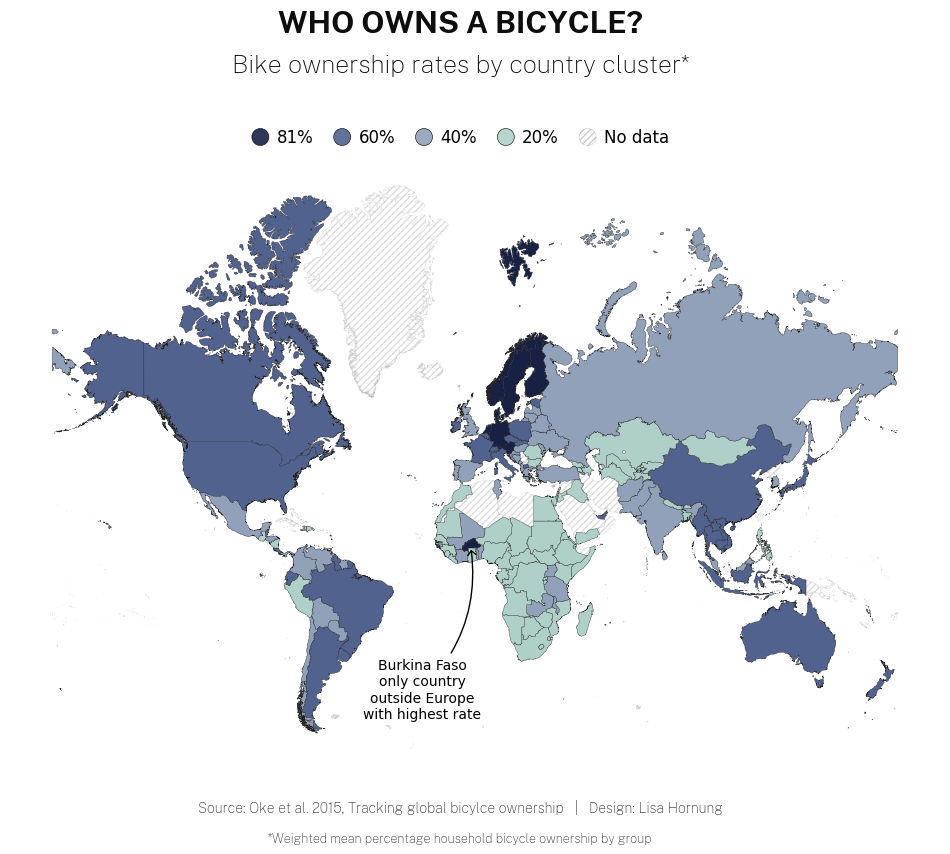

In [179]:
gdf = gdf.to_crs(3857)
fig, ax = plt.subplots(1,1, figsize=(12,10))

# plot data -------------------------------------------
gdf.plot("Group", ax=ax, alpha=1, legend=False, cmap=cmap, edgecolor="#222222", linewidth=0.25,
             #legend_kwds={'orientation':'horizontal', 'shrink': 0.3, 'pad': 0.03, 'alpha':1}
             )

#plot countries with missing data
gdf.loc[(gdf["Group"].isna()) &
         (gdf["area_size"] <=20619389701670)].plot(ax=ax, color="white", edgecolor="#555555",
                                               linewidth=0.3, hatch='/////', alpha=0.2)
ax.axis("off")

# plot custom legends -------------------------------------------
lg = fig.add_axes([0.32,0.8,0.3,0.05])
kw = dict(marker='o', s=150, alpha=0.9, linewidths=0.45, ec="black")
lg.scatter(x=[2,3,4,5], y=[0.8]*4,  color=get_hex('GeorgiaOKeeffe')[1:], **kw, clip_on=False)
lg.scatter(x=[6], y=[0.8],  color="white", edgecolor="black", s=150, linewidth=0.45, hatch='/////', alpha=0.2, clip_on=False)
labels = ["81%", "60%", "40%", "20%", "No data"]
for i, x_pos in enumerate([6,5,4,3,2][::-1]):
    lg.text(x_pos+0.2, 0.8, labels[i], fontsize=12, ha="left", va="center")
lg.axis("off")


# annotations ---------------------------
ax.annotate('Burkina Faso\nonly country\noutside Europe\nwith highest rate',
             xy=(float(gdf[gdf["ISO"]=="BFA"]["geometry"].centroid.x.iloc[0]), float(gdf[gdf["ISO"]=="BFA"]["geometry"].centroid.y.iloc[0])-100000),
             xycoords='data', xytext=(-35, -80), textcoords='offset points', 
            fontsize=10, ha='center', va='top', annotation_clip=False, 
            arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.3", facecolor='black',connectionstyle="arc3,rad=0.25"))

# title and footer ------------------
plt.figtext(0.5,0.93, "Who owns a bicycle?".upper(), fontproperties=title_font, fontsize=22, ha="center", alpha=0.95)
plt.figtext(0.5,0.89, "Bike ownership rates by country cluster*", fontproperties=label_font, fontsize=18, ha="center", alpha=0.95)
plt.figtext(0.5,0.15, "Source: Oke et al. 2015, Tracking global bicylce ownership   |   Design: Lisa Hornung", fontsize=10, ha="center", alpha=0.8, fontproperties=label_font,)
plt.figtext(0.5,0.12, "*Weighted mean percentage household bicycle ownership by group", fontsize=9, ha="center", alpha=0.8, fontproperties=label_font,)

# save
plt.savefig("global-bike-ownership-map.png", bbox_inches='tight', dpi=120, pad_inches=0.5)

plt.show()

# Playground

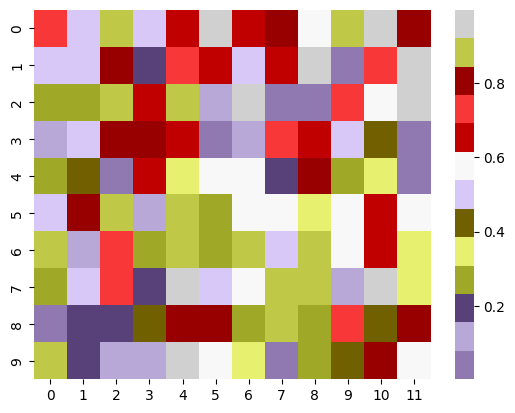

In [10]:
data = np.random.rand(10, 12)

cmap = load_cmap('machoke', type='discrete', type_warning = False)

sns.heatmap(data, cmap=cmap)
plt.show()

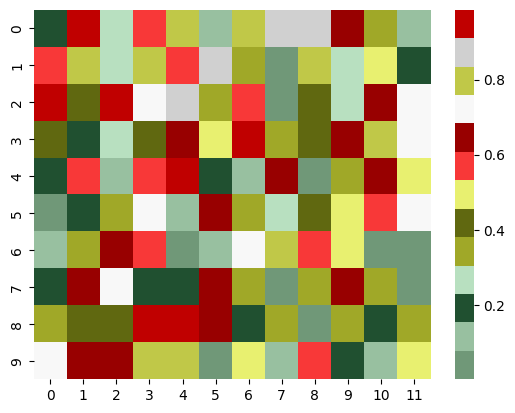

In [11]:
data = np.random.rand(10, 12)

cmap = load_cmap('machop', type='discrete', type_warning = False)

sns.heatmap(data, cmap=cmap)
plt.show()

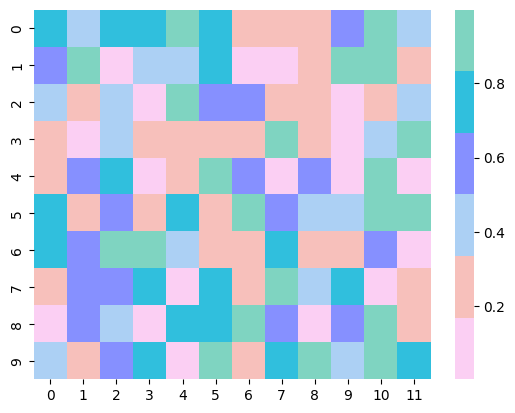

In [13]:
data = np.random.rand(10, 12)

cmap = load_cmap('mallsoft', type='discrete', type_warning = False)

sns.heatmap(data, cmap=cmap)
plt.show()

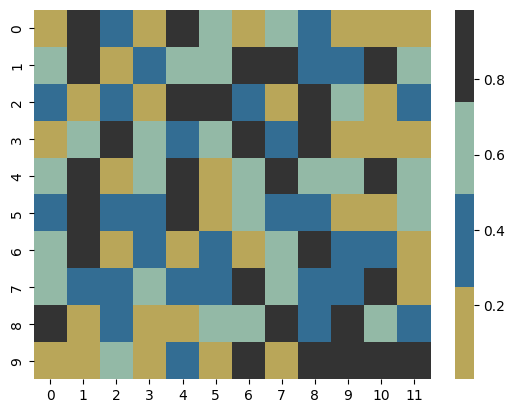

In [23]:
data = np.random.rand(10, 12)

cmap = load_cmap('nolan_ned', type='discrete', type_warning = False, keep_first_n=4)

sns.heatmap(data, cmap=cmap, alpha=0.8)
plt.show()

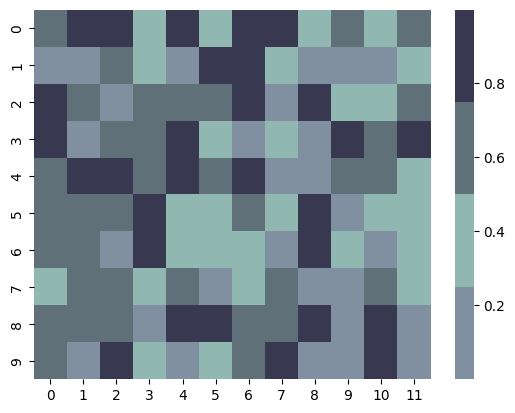

In [29]:
data = np.random.rand(10, 12)

cmap = load_cmap('nosepass', type='discrete', type_warning = False, keep_first_n=4)
sns.heatmap(data, cmap=cmap, alpha=1)
plt.show()

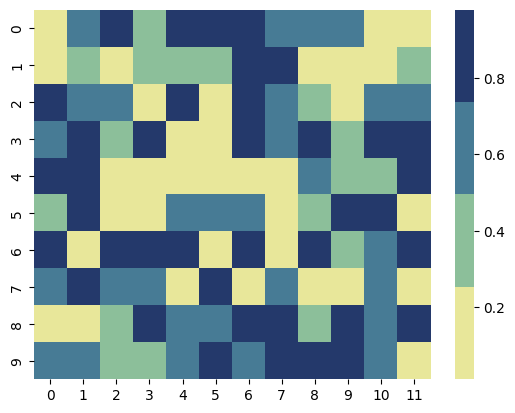

In [34]:
data = np.random.rand(10, 12)

cmap = load_cmap('Ernst', type='discrete', type_warning = False, keep=[True, False, True, False, True, False, True, False])

sns.heatmap(data, cmap=cmap, alpha=1)
plt.show()

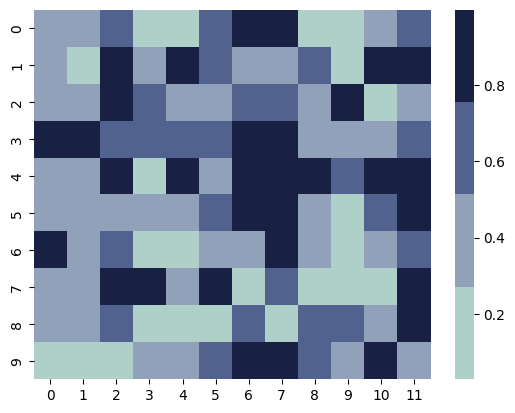

In [41]:
data = np.random.rand(10, 12)

cmap = load_cmap('GeorgiaOKeeffe', type='discrete', reverse=True, type_warning = False, keep=[True, True, True, True, False ])

sns.heatmap(data, cmap=cmap, alpha=1)
plt.show()